# Inserção dos pacotes

In [ ]:
pip install scikeras

In [ ]:
from pathlib import Path
from google.colab import drive
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random as rd
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Setar a semente
rd.seed(2023)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_PATH = Path('/content/drive/MyDrive/').resolve()
DATA_PATH = DRIVE_PATH / 'Pessoal/Pessoal/TCC - Beto/data'

# Leitura dos dados

Os dados são referentes a ressonâncias magnéticas funcionais (fMRI) de 242 pacientes com síndrome do espectro austista (ASD) e 257 pacientes sem autismo - desenvolvimento típico (TD). As partes do cérebro foram agrupadas em 122 regiões de interesse, e foi coletado a situação de cada região ao longo do tempo, formando uma matriz bidimensional para cada paciente.

In [ ]:
def read_data(file_path):
    data = pd.read_csv(file_path, sep=",", index_col=False, header = None)
    final_data = np.array(data)
    return final_data

In [ ]:
# dados de pacientes com autismo (ASD - autism spectrum disorder)
asd = [
    read_data(file_path)
    for file_path in DATA_PATH.glob('*ASD/*.csv')
]

In [ ]:
# dados de pacientes sem autismo (TD - typical development)
td = [
    read_data(file_path)
    for file_path in DATA_PATH.glob('*TD/*.csv')
]

# Matriz de correlação

Após a leitura dos dados, pretende-se calcular a matriz de correlação dos dados de cada paciente, a fim de analisar a relação entre as regiões ao longo do tempo. Para a matriz de correlação, é necessário que as colunas possuam variância. Caso contrário, a matriz de correlação conterá NaN's. Então, verifica-se tal condição.

In [ ]:
# Função que verifica se a matriz de dados possui alguma coluna sem variância
def verify_column(matrix):
  result = True
  matrix = pd.DataFrame(matrix)
  matrix.rename(columns={x: str(int(x)) for x in range(0, 122)}, inplace=True)
  for column_index in matrix.columns:
    if len(matrix[column_index].unique()) == 1:
      print("Column index:", column_index)
      print("Unique value:", matrix[column_index].unique())
      result = False
  return result

In [ ]:
# Função que exclui as colunas sem variância
def drop_columns(matrix):
  matrix = pd.DataFrame(matrix)
  matrix.rename(columns={x: str(int(x)) for x in range(0, 122)}, inplace=True)
  for column_index in matrix.columns:
    if len(matrix[column_index].unique()) == 1:
      matrix.drop(columns = column_index, inplace = True)
  return matrix

In [ ]:
# Código para verificar quais colunas não possuem variância entre os dados
# dos pacientes com e sem autismo
for n in range(0, 242):
    if not verify_column(asd[n]):
      print("Observation (asd)", n)
      print("--")

for n in range(0, 258):
    if not verify_column(td[n]):
      print("Observation (td)", n)
      print("--")

Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Observation (asd) 0
--
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Observation (asd) 1
--
Column index: 45
Unique value: [0.]
Observation (asd) 2
--
Column index: 13
Unique value: [0.]
Column index: 45
Unique value: [0.]
Observation (asd) 3
--
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Observation (asd) 5
--
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Observation (asd) 6
--
Column index: 10
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 53
Unique value:

Como observado, há diversas colunas que não possuem variabilidade. Dessa forma, optou-se por mantê-las e aplicar 0 às entradas da matriz de correlação referente a essas colunas.

In [ ]:
y = list()

In [ ]:
asd_data_corr = list()
for n in range(0, 242):
  asd_data = pd.DataFrame(asd[n])
  #asd_data.drop(columns = [45, 17, 13, 107, 10, 60, 53, 61, 64, 69], inplace = True)
  #if not verify_column(np.array(asd_data)):
  #  break
  obs_asd_data_corr = asd_data.corr(method = "spearman")
  #obs_asd_data_corr.to_csv(DATA_PATH / f'correlation/ASD/ASD{n}.csv', index = None)
  asd_data_corr.append(obs_asd_data_corr)
  y.append(1)

Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 10
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 53
Unique value: [0.]
Column index: 61
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 13
Unique

In [ ]:
td_data_corr = list()
for n in range(0, 258):
  td_data = pd.DataFrame(td[n])
  #td_data.drop(columns = [45, 17, 13, 107, 10, 60, 53, 61, 64, 69], inplace = True)
  #if not verify_column(np.array(td_data)):
  #    break
  obs_td_data_corr = td_data.corr(method = "spearman")
  #obs_td_data_corr.to_csv(DATA_PATH / f'correlation/TD/TD{n}.csv', index = None)
  td_data_corr.append(obs_td_data_corr)
  y.append(0)

Column index: 13
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 10
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 53
Unique value: [0.]
Column index: 61
Unique value: [0.]
Column index: 64
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 107
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 13
Unique value: [0.]
Column index: 17
Unique value: [0.]
Column index: 45
Unique value: [0.]
Column index: 53
Unique value: [0.]
Column index: 61
Unique 

Na sequência, junta-se as matrizes observadas para os pacientes com e sem autismo e aplica-se uma transformação para que os valores pertençam ao intervalo [0, 1].

In [ ]:
X = np.array(asd_data_corr + td_data_corr)

In [ ]:
X[np.isnan(X)] = 0

In [ ]:
np.shape(X)

(499, 122, 122)

In [ ]:
X_transf = np.sqrt(1 + X)/np.sqrt(2)

In [ ]:
y = np.array(y)

Divide-se os dados entre treino - 75% - e teste - 25%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transf, y, test_size=0.25, random_state=1234)

E considera-se o vetor de resposta como categórico.

In [ ]:
input_shape = (122, 122, 1)
num_classes = 2

In [ ]:
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

# Tunando o número de camadas

In [ ]:
def create_model(layers, activation):
        model= keras.Sequential()
        for i, nodes in enumerate(layers):
            if i==0:
                model.add(Dense(nodes, input_shape = input_shape))
                model.add(Activation(activation))
            else:
                model.add(Dense(nodes))
                model.add(Activation(activation))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(2))
        model.add(Activation(activation))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

model= KerasClassifier(model=create_model, verbose=0, activation='relu', layers=20)

In [ ]:
layers=[[50],[50, 25]]
activations = ["relu", "softmax"]
param_grid = dict(layers=layers, activation=["relu"], batch_size=[100, 50], epochs=[5, 10])
grid = GridSearchCV(estimator=model, param_grid=param_grid)
#grid_result = grid.fit(X_train, y_train_categorical)

In [ ]:
#[grid_result.best_score_,grid_result.best_params_]

# Treino da rede neural

A partir da matriz de correlação, treina-se uma rede neural com duas camadas ocultas, e 50 e 25 filtros, utilizando a função de ativação "relu". A camada de saíde possui 2 filtros, um para cada categoria, e utiliza-se a função de ativação "softmax". Além disso, usa-se tamanho 100 para o tamanho do lote (batch size) e 10 épocas (epochs). A função de perda utilizada é a entropia binária (binary_crossentropy) e a métrica, a área sob a curva ROC (AUC).

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        Dense(50, activation="relu"),
        Dense(25, activation="relu"),
        Flatten(),
        Dropout(0.5),
        Dense(2, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 122, 122, 50)      100       
                                                                 
 dense_1 (Dense)             (None, 122, 122, 25)      1275      
                                                                 
 flatten (Flatten)           (None, 372100)            0         
                                                                 
 dropout (Dropout)           (None, 372100)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 744202    
                                                                 
Total params: 745577 (2.84 MB)
Trainable params: 745577 (2.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 100
epochs = 10

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["AUC"])

model_history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 3.7575 - auc: 0.4682 - val_loss: 5.1621 - val_auc: 0.6034
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 4.9123 - auc: 0.4957 - val_loss: 3.9540 - val_auc: 0.5310
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 3.0540 - auc: 0.4825 - val_loss: 3.0063 - val_auc: 0.4690
Epoch 4/10
3/3 [==============================] - 10s 3s/step - loss: 2.9660 - auc: 0.4981 - val_loss: 1.7534 - val_auc: 0.4690
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 1.1682 - auc: 0.5163 - val_loss: 1.6140 - val_auc: 0.5310
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 1.7588 - auc: 0.5038 - val_loss: 1.0260 - val_auc: 0.5991
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.8134 - auc: 0.5591 - val_loss: 0.9545 - val_auc: 0.4362
Epoch 8/10
3/3 [==============================] - 6s 2s/step - loss: 1.0405 - auc: 0.4880 - val_loss: 1.0916 -

# Análise

Em seguida, analisa-se a matriz de confusão e a curva ROC, além de métricas como AUC, recall, F1 e precisão baseando-se na predição do diagnóstico dos dados de teste.

In [ ]:
# Código para tomar somente a probabilidade predita do diagnóstico positivo para autismo
y_pred_prob_vector = model.predict(X_test)
y_pred_prob = list()
for i in range(len(y_test)):
    y_pred_prob.append(y_pred_prob_vector[i][1])

4/4 [==============================] - 1s 209ms/step


In [ ]:
# Função para prever o diagnóstico utilizando determinado ponto de corte
def predict_value(y_predicted, threshold = 0.5):
    y = list()
    for index in range(len(y_predicted)):
      if y_predicted[index][0] > threshold:
        y.append(0)
      else:
        y.append(1)
    return np.array(y)

In [ ]:
model.predict(X_test)

4/4 [==============================] - 1s 204ms/step


array([[0.74203455, 0.25796545],
       [0.75716937, 0.24283054],
       [0.75482553, 0.24517453],
       [0.7101891 , 0.2898109 ],
       [0.7704659 , 0.22953403],
       [0.7627048 , 0.23729521],
       [0.7439495 , 0.25605047],
       [0.75246966, 0.24753045],
       [0.76013803, 0.23986198],
       [0.7530828 , 0.24691716],
       [0.7343824 , 0.26561758],
       [0.7382367 , 0.26176333],
       [0.7418052 , 0.25819474],
       [0.74148905, 0.2585109 ],
       [0.75315   , 0.24684998],
       [0.7334091 , 0.26659092],
       [0.75429857, 0.24570131],
       [0.7539337 , 0.24606629],
       [0.75915134, 0.24084865],
       [0.7605132 , 0.23948674],
       [0.75422966, 0.24577022],
       [0.74258035, 0.2574196 ],
       [0.7459509 , 0.25404906],
       [0.73071724, 0.26928273],
       [0.7485896 , 0.25141042],
       [0.74319017, 0.25680983],
       [0.72676814, 0.27323174],
       [0.73036945, 0.26963055],
       [0.7579891 , 0.24201085],
       [0.726523  , 0.273477  ],
       [0.

In [ ]:
y_pred = predict_value(model.predict(X_test), 0.73)

4/4 [==============================] - 2s 551ms/step


## Curva ROC

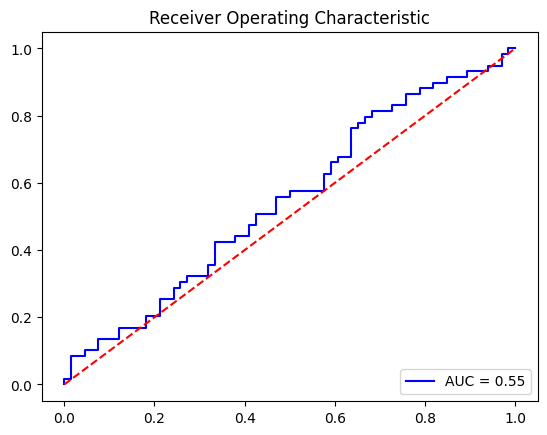

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

## Matriz de confusão

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[59,  7],
       [51,  8]])

## Recall = $\frac{VP}{VP + FN}$
em que VP: verdadeiros positivos e FN: falsos negativos. Ou seja, é a proporção de acertos entre todos os valores verdadeiramente positivos (com autismo)


In [ ]:
metrics.recall_score(y_test, y_pred)

0.13559322033898305

## Precisão = $\frac{VP}{VP + FP}$
em que VP: verdadeiros positivos e FP: falsos positivos. Ou seja, é a proporção de acertos entre todos os valores preditos positivos (com autismo)

In [ ]:
metrics.precision_score(y_test, y_pred)

0.5333333333333333

## F$_1 = 2 * \frac{\text{precisão } * \text{ recall}}{\text{precisão } + \text{ recall}}$

In [ ]:
metrics.f1_score(y_test, y_pred)

0.21621621621621623

## Acurácia = $\frac{VP + VN}{VP + VN + FP + FN}$
ou seja, é a quantidade de acertos de diagnósticos do modelo.

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.536